# Bayesian A/B Testing


## Hypothetical Scenario 

In our hypothetical example, we will pretend we are a small team of statisticians at the Office of Inspector General (OIG), tasked with auditing for financial fraud and taxpayer fund misuse. The team has two methods of auditing the financial practices of the Department of Veterans Affairs: on-site audits or desk audits. Desk audits are cheaper, but are they more effective? 

1. **Program A**: Auditors conduct on-site physical audits at the locations under investigation. Our past data shows that **9 out of 60 (15%)** audits resulted in fraud. This is the *observed frequency* of program A uncovering fraud. It's not necessarily the *true frequency* or the *true probability* that program A uncovers fraud since these data are a sample. The data do not consider the plausible alternative audits under program A that could have occurred but did not.


2. **Program B**: Auditors conduct desk audits, where all work is conducted from the home office with no physical presence at the location under investigation. Our past data shows that **4 out of 35 (13%)** audits resulted in fraud.

While we can observe some differences in the observed data upon first glance, the data available to us are highly uncertain quantities. 

## Our Goals

We want to express the uncertainty of our beliefs regarding the differences in fraud detection rate of program A and program B. The fraud detection rates of each program are parameters defined as follows:

* $p_A$: program A's fraud detection rate
* $p_B$: program B's fraud detection rate 

We will model this uncertainty using Bayesian inference techniques to learn the most likely true probabilities of fraud under programs A and B, given the data. By doing so, we can make intuitive statements such as:

"*There's an X% probability that program A is more effective than program B due to its higher fraud rate.*" 

or 

"*We are 95% confident that program A's fraud detection rate could be anywhere from Y% to Z% better than program B's.*"

## A Bayesian Approach

A Bayesian inference approach to statistics allows us to carry out the above goals by treating our parameters of interest as random variables, and the data as fixed quantities. By doing this, we can generate many samples from probability distributions that describe our parameters of interest, which we can perform data analysis on to arrive at statistical inferences. To do this, we need a distribution for prior beliefs about program A and B, our data for program A and B (to model a generative likelihood function), and combine these to arrive at posterior beliefs (updating original beliefs after observing data) about their respective fraud detection rates.

\begin{align}
 P( RateOfFraud | data ) = & \frac{ P(data | RateOfFraud) P(RateOfFraud) } {P(data) } \\\\[5pt]
& \propto P(data | RateOfFraud) P(RateOfFraud)\;\; (\propto \text{is proportional to })
\end{align}


* P( RateOfFraud | data ): **the posterior distribution about the parameter of interest**. This is the probability distribution of our parameter, updating from prior probabilities after conditioning on the data. 



* P(data | RateOfFraud): **the likelihood of the data.** A generative model (likelihood function) describing the plausibility of the observed data for every possible parameter value of the RateOfFraud.



* P(RateOfFraud): **the prior credibility of the parameter**. It is the initial probability value assigned to each possible parameter value, encoding prior beliefs or information about the parameters.


* P(data): the probability of the data. It's the sum of the product of all possible combinations of the likelihood and prior components. It's role as the denominator is to standardize the likelihood x prior so that the posterior distribution sums to 1, representing a proper PDF or PMF. 


* data: our observed data.



## Uniform Prior Beliefs

Under these assumptions, we'll assume that all probabilities from 0 to 1 are equally likely for program A's and program B's fraud rates. That means that before seeing the data, a 0% fraud rate was just as plausible as 50% and 100% for either program A or B. Probably unrealistic, but it's somewhere to start from. A uniform prior effectively gives full weight to the data. 

In [1]:
# https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline/43028034
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize


def binomial_grid_approx(successes, n_trials, grid_length=100, 
                         uniform_prior=True, beta_shape1=1, beta_shape2=1):
    """Estimate the posterior distribution of set of 
    observations that can be modeled as a binomial distribution 
    Use grid approximation. Assumes a uniform prior. If you want
    to set a prior probability distribution over the parameter of interest, 
    set the beta distributions shape parameters."""
    
    # define grid of possible values of p
    p_grid = np.linspace(0, 1, grid_length)
    
    # define the prior distribution of p_grid
    if uniform_prior == True:
        prior = np.ones(grid_length)/grid_length
    else:
        prior = stats.beta.pdf(p_grid, a=beta_shape1, b=beta_shape2)
    
    # calculate the prob mass function, given different values of p. 
    likelihood = stats.binom.pmf(successes, n_trials, p_grid) 
    # estimate the posterior distribution: P(data | p_grid) * P(p_grid)
    unnormalized_posterior = likelihood * prior # vectorized math

    posterior = unnormalized_posterior / unnormalized_posterior.sum()
    
    return p_grid, posterior

In [2]:
#p_grid = np.linspace(0, 1, 100)
#print(p_grid)
#prior = np.ones(100)/100
#print(prior)
#print(stats.beta.pdf(p_grid, a=3, b=7))
#plt.plot(p_grid, stats.beta.pdf(p_grid, a=3, b=7), 'o-')

Now run the function over the 2 observed datasets to return posterior probability distributions for program A and program B's fraud rates. 

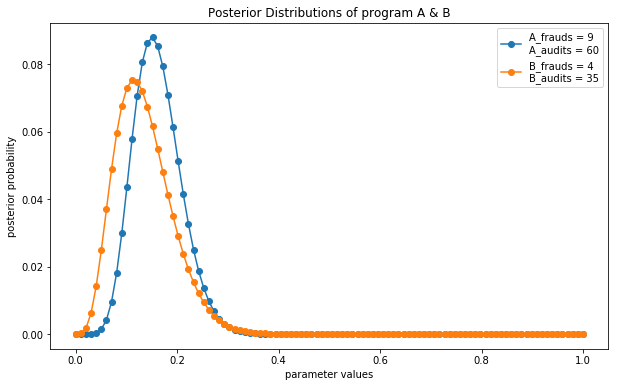

In [3]:
figsize(10, 6)

# observed data. YOU CAN TWEAK THIS TO SEE HOW DISTRIBUTIONS AND INFERENCE CHANGE!
A_fraud, A_audits = 9, 60
B_fraud, B_audits = 4, 35

p_grid, posterior_A = binomial_grid_approx(A_fraud, A_audits, 100, True)
p_grid, posterior_B = binomial_grid_approx(B_fraud, B_audits, 100, True)


plt.plot(p_grid, posterior_A, 'o-', label='A_frauds = {}\nA_audits = {}'.format(A_fraud, A_audits))
plt.plot(p_grid, posterior_B, 'o-', label='B_frauds = {}\nB_audits = {}'.format(B_fraud, B_audits))
plt.title('Posterior Distributions of program A & B')
plt.ylabel('posterior probability')
plt.xlabel('parameter values')
plt.legend(loc=0)
plt.show()

The above grid approximation approach produces an analytical posterior probability distributions over our **2 parameters of interest**:

* $p_A$: program A's fraud detection rate
* $p_B$: program B's fraud detection rate 

In order to compare these posterior probability distributions to each other, we should draw sample values from each of them, then count and compare their frequencies over different intervals (*a practical way to calculate integrals*. See Statistical Rethinking Ch.2). Do so will enable us to answer specific probability questions about the data by simply counting frequencies!

## Generate Samples from the Posterior 

Imagine we draw 10,000 samples from of program A's posterior distribution, $p_A$. We can think of each sample being drawn from a bucket that's filled with **parameter values** that exist proportionally to $p_A$'s posterior distribution graphed above. For instance, about 9% of the values to pick out of the bucket will have a sample value of $p_A$ = 16%, the mode of program A's posterior distribution. **The key takeaway is that if we sample a large enough number of times from the posterior, the sample parameter values will appear proportionally to the exact posterior distribution.** All remaining data analysis then simply becomes a matter of tallying frequencies to arrive at probabilistic inferences.

In [4]:
np.random.seed(123)
post_samples_A = np.random.choice(p_grid, size=10000, replace=True, p=posterior_A)
post_samples_B = np.random.choice(p_grid, size=10000, replace=True, p=posterior_B)
post_samples_diff = post_samples_A - post_samples_B

## Use the Samples to Generate Summary Statistics and Answer  Questions

Generating and then graphing 10,000 samples from the posterior distributions of $p_A$ and $p_B$, we've simply replicated the original graph from before, but now we have an array of data points of specific sample values of $p_A$ and $p_B$ to conduct easy data analysis for inference.


### Which range of parameter values for $p_A$ and $p_B$ contains most of the probability mass?

For instance, using 10,000 samples frmo the posterior distributions, the below graphs in the 1st column are able to summarize the [**90% highest density interval (HDI)**](https://en.wikipedia.org/wiki/Credible_interval), which is the narrowest interval between which 90% of the most plausible values (highest density) of $p_A$ and $p_B$ exist, given the data and prior assumptions. The graphs in the 2nd column are an alternative viz of the probabilistic sampling process from sample 1 - 10,000 from each posterior distribution.

**We clearly see that $p_A$ and $p_B$'s HDI regions are comparable and wide, reflecting the observed data and the increased uncertainty from having very small data samples!** Additionally, we see less of a peak around $p_B$'s central tendency because there are almost half the sample data points from program B as program A indicating even more uncertainty for $p_B$'s true central tendency. More observed data would yield tighter intervals.

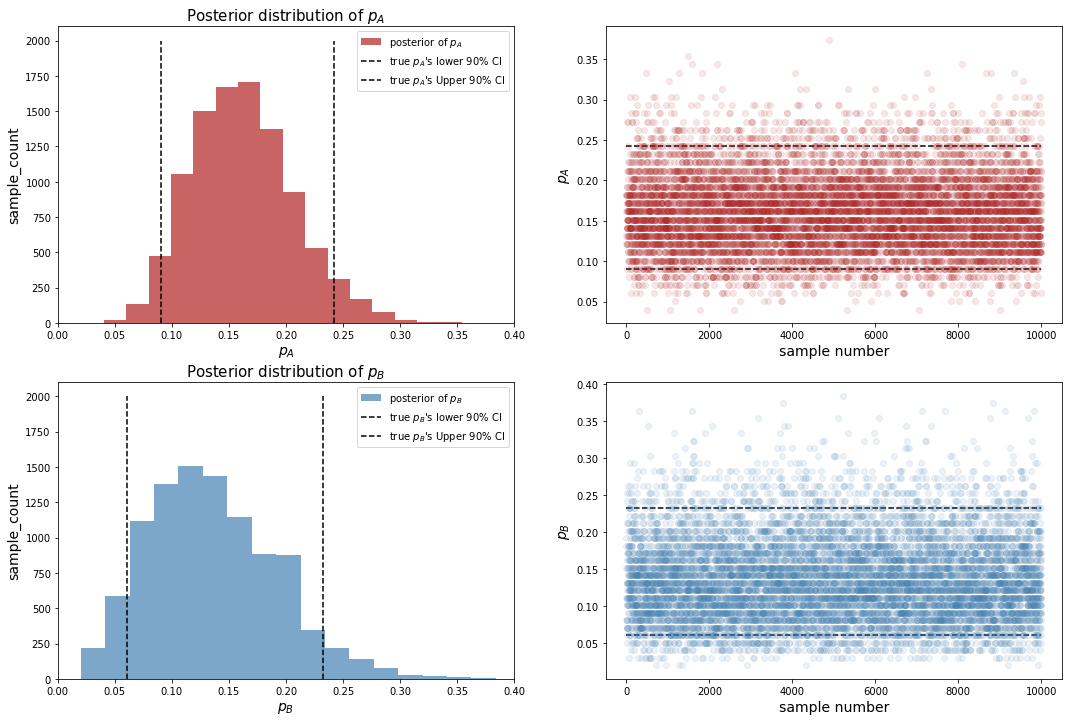

In [21]:
fig, ax = plt.subplots(2,2, figsize=(18,12))

# posterior p_A histogram summary, and trace of the p_A samples
ax[0,0].set_xlim(0, 0.4)
ax[0,0].hist(post_samples_A, histtype='stepfilled', bins = 17, alpha=0.7,
         label="posterior of $p_A$", color="firebrick", density=False)
ax[0,0].vlines(np.percentile(post_samples_A, 5), 0, 2000, linestyle="--", label="true $p_A$'s lower 90% CI")
ax[0,0].vlines(np.percentile(post_samples_A, 95), 0, 2000, linestyle="--", label="true $p_A$'s Upper 90% CI")
ax[0,0].legend(loc="upper right")
ax[0,0].set_xlabel('$p_A$', fontsize=14)
ax[0,0].set_ylabel('sample_count', fontsize=14)
ax[0,0].set_title("Posterior distribution of $p_A$", fontsize=15)

ax[0,1].plot(post_samples_A, 'o', alpha=0.1, color="firebrick")
ax[0,1].hlines(np.percentile(post_samples_A, 5), 0, 10000, linestyle="--", label="true $p_A$'s lower 90% CI")
ax[0,1].hlines(np.percentile(post_samples_A, 95), 0, 10000, linestyle="--", label="true $p_A$'s Upper 90% CI")
ax[0,1].set_xlabel('sample number', fontsize=14)
ax[0,1].set_ylabel('$p_A$', fontsize=14)


# posterior p_B histogram summary, and trace of the p_B samples
ax[1,0].set_xlim(0, 0.4)
ax[1,0].hist(post_samples_B, histtype='stepfilled', bins = 17, alpha=0.7,
         label="posterior of $p_B$", color="steelblue", density=False)
ax[1,0].vlines(np.percentile(post_samples_B, 5), 0, 2000, linestyle="--", label="true $p_B$'s lower 90% CI")
ax[1,0].vlines(np.percentile(post_samples_B, 95), 0, 2000, linestyle="--", label="true $p_B$'s Upper 90% CI")
ax[1,0].legend(loc="upper right")
ax[1,0].set_xlabel('$p_B$', fontsize=14)
ax[1,0].set_ylabel('sample_count', fontsize=14)
ax[1,0].set_title("Posterior distribution of $p_B$", fontsize=15)

ax[1,1].plot(post_samples_B, 'o', alpha=0.1, color="steelblue")
ax[1,1].hlines(np.percentile(post_samples_B, 5), 0, 10000, linestyle="--", label="true $$p_B$'s lower 90% CI")
ax[1,1].hlines(np.percentile(post_samples_B, 95), 0, 10000, linestyle="--", label="true $$p_B$'s Upper 90% CI")
ax[1,1].set_xlabel('sample number', fontsize=14)
ax[1,1].set_ylabel('$p_B$', fontsize=14)

plt.show()

### Given the data, what's the probability that program A has a higher fraud detection rate than program B?

Having generated 10,000 samples from $p_A$ and $p_B$'s posterior distributions, answering this becomes trivial. We just need to tally the proportion of samples from $p_A$'s posterior that are higher than $p_B$'s posterior distribution.

Graphically, this is expressed by calculating the difference between $p_A$ - $p_B$ and observing how many of those differences are above 0. From the answer below, it's pretty clear that given the data, we cannot conclude with high probability that program A is more effective than program B. 

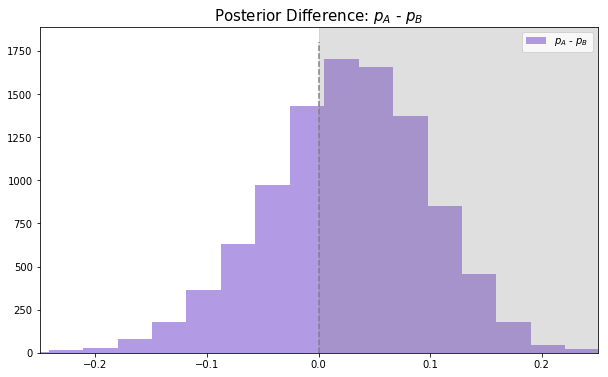

There is only a 63.0% probability that program A has a higher fraud rate than program B


In [42]:
figsize(10, 6)

plt.xlim(-0.25, 0.25)
plt.hist(post_samples_diff, histtype='stepfilled', bins = 18, alpha=0.7,
         label="$p_A$ - $p_B$", color="mediumpurple", density=False)
plt.vlines(0, 0, 1800, linestyle="--", colors='grey')
plt.axvspan(0, 0.25, alpha=0.25, color='grey') # https://stackoverflow.com/questions/23248435/fill-between-two-vertical-lines-in-matplotlib
plt.title("Posterior Difference: $p_A$ - $p_B$", fontsize=15)
plt.legend(loc="upper right")
plt.show()

prob = round(100 * np.mean(post_samples_A > post_samples_B))
print('There is only a {}% probability that program A has a higher fraud rate than program B'.format(prob))

### How different is program A's fraud detection rate from program B's fraud detection rate at 90% confidence?

Having generated 10,000 samples of $p_A$ - $p_B$'s, since these data are Gaussian-like distributed, we simply need to identify the middle 90% of $p_A$ - $p_B$ probability mass.

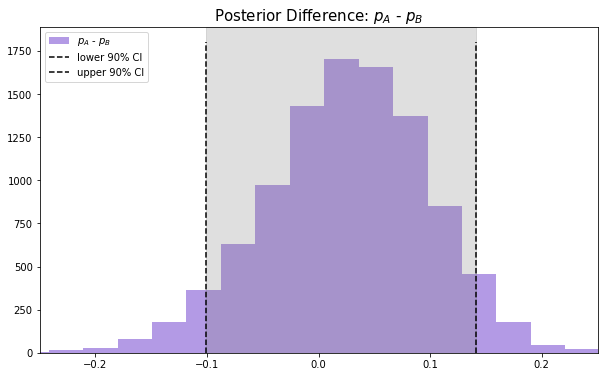

We are 90% confident that program A's fraud detection rate is anywhere from -10% less to 14% higher than program B


In [43]:
CI_90 = (np.percentile(post_samples_diff, 5), np.percentile(post_samples_diff, 95))

figsize(10, 6)

plt.xlim(-0.25, 0.25)
plt.hist(post_samples_diff, histtype='stepfilled', bins = 18, alpha=0.7,
         label="$p_A$ - $p_B$", color="mediumpurple", density=False)
plt.vlines(CI_90[0], 0, 1800, linestyle="--", label="lower 90% CI")
plt.vlines(CI_90[1], 0, 1800, linestyle="--", label="upper 90% CI")
plt.axvspan(CI_90[0], CI_90[1], alpha=0.25, color='grey') # https://stackoverflow.com/questions/23248435/fill-between-two-vertical-lines-in-matplotlib
plt.title("Posterior Difference: $p_A$ - $p_B$", fontsize=15)
plt.legend(loc="upper left")
plt.show()

# 10% type I error rate.
print("We are 90% confident that program A's fraud detection rate is anywhere from {:.0f}% less to {:.0f}% higher than program B".format(100 * CI_90[0], 100 * CI_90[1]))

## Recreate the Solution with PyMC3

Let's recreate the analysis using `PyMC3` and its MCMC sampling algorithms instead of the 'by hand' grid approximation approach. If we get the same results, we know we're doing this thing right-ish. . . This model fits three parameters, $p_A$, $p_B$, and their difference *A_minus_B*. Samples from the respective posterior distributions for each parameter are automatically generated using the Metropolis Hastings MCMC algorithm to probabilistically find and explore high density areas of the parameter space.

In [11]:
# Generate and store the individual audit samples from each program.
program_A_data = np.zeros(60)
program_A_data[:9] = 1
np.random.shuffle(program_A_data)

program_B_data = np.zeros(35)
program_B_data[:4] = 1
np.random.shuffle(program_B_data)

In [12]:
import pymc3 as pm

with pm.Model() as model:
    p_A = pm.Uniform('p_A', lower=0, upper=1) # parameter space for A will have a uniform prior distribution.
    p_B = pm.Uniform('p_B', lower=0, upper=1) # parameter space for B will have a uniform prior distribution.
    
    # define our deterministic variable to track in MCMC sampling
    A_minus_B = pm.Deterministic('A_minus_B', p_A - p_B)
    
    # define our stochastic variables
    observed_A = pm.Bernoulli('observed_A', p=p_A, observed=program_A_data)
    observed_B = pm.Bernoulli('observed_B', p=p_B, observed=program_B_data)
    
    # sampling algorithm
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)
    burned_trace=trace[1000:]
    

/Users/bhoeft/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:05<00:00, 3822.77draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [13]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
A_minus_B_samples = burned_trace["A_minus_B"]

p_A_hdi = pm.hpd(p_A_samples, alpha=0.10) #alpha = type 1 error rate.
p_B_hdi = pm.hpd(p_B_samples, alpha=0.10) 
A_minus_B_hdi = pm.hpd(A_minus_B_samples, alpha=0.10)

print('credibile values for p_A: {}'.format(p_A_hdi))
print('credibile values for p_B: {}'.format(p_B_hdi))

prob = round(100 * np.mean(p_A_samples > p_B_samples))
print('There is only a {}% probability that program A has a higher fraud rate than program B'.format(prob))

credibile values for p_A: [0.0834151  0.23240057]
credibile values for p_B: [0.04118194 0.21932831]
There is only a 66.0% probability that program A has a higher fraud rate than program B


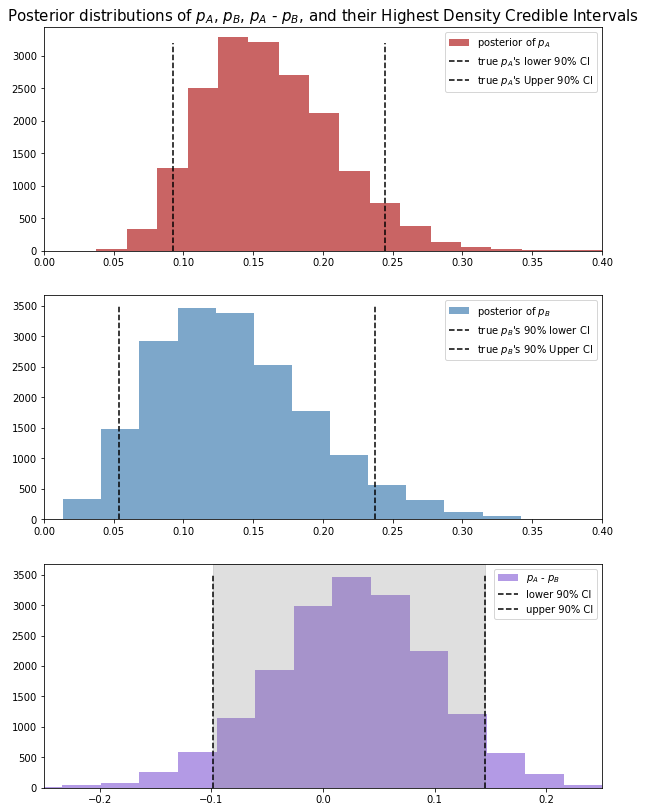

We are 90% confident that program A's fraud detection rate is anywhere from -10% less to 15% higher than program B


In [22]:
figsize(10, 14)

ax = plt.subplot(311)

plt.xlim(0, 0.4)
plt.hist(p_A_samples, histtype='stepfilled', bins = 17, alpha=0.7,
         label="posterior of $p_A$", color="firebrick", density=False)
plt.vlines(np.percentile(p_A_samples, 5), 0, 3200, linestyle="--", label="true $p_A$'s lower 90% CI")
plt.vlines(np.percentile(p_A_samples, 95), 0, 3200, linestyle="--", label="true $p_A$'s Upper 90% CI")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, $p_A$ - $p_B$, and their Highest Density Credible Intervals", fontsize=15)

ax = plt.subplot(312)

plt.xlim(0, 0.4)
plt.hist(p_B_samples, histtype='stepfilled', bins = 17, alpha=0.7,
         label="posterior of $p_B$", color="steelblue", density=False)
plt.vlines(np.percentile(p_B_samples, 5), 0, 3500, linestyle="--", label="true $p_B$'s 90% lower CI")
plt.vlines(np.percentile(p_B_samples, 95), 0, 3500, linestyle="--", label="true $p_B$'s 90% Upper CI")
plt.legend(loc="upper right")


ax = plt.subplot(313)

plt.xlim(-0.25, 0.25)
plt.hist(A_minus_B_samples, histtype='stepfilled', bins = 18, alpha=0.7,
         label="$p_A$ - $p_B$", color="mediumpurple", density=False)
plt.vlines(np.percentile(A_minus_B_samples, 5), 0, 3500, linestyle="--", label="lower 90% CI")
plt.vlines(np.percentile(A_minus_B_samples, 95), 0, 3500, linestyle="--", label="upper 90% CI")
plt.axvspan(np.percentile(A_minus_B_samples, 5), 
            np.percentile(A_minus_B_samples, 95), 
            alpha=0.25, color='grey')
plt.legend(loc="upper right")
plt.show()


print("We are 90% confident that program A's fraud detection rate is anywhere from {:.0f}% less to {:.0f}% higher than program B".format(100 * A_minus_B_hdi[0], 100 * A_minus_B_hdi[1]))

## Concluding Thoughts

For a simple A/B testing framework where we're only measuring single parameters between 2 groups, Bayesian inference can be applied using grid approximation techniques or using a MCMC sampling engine like `PyMC3` that abstracts a lot of manual labor, but generates the same results. 

Additionally, for the toy example above, we should make a recommendation to a decision maker. Give the statistical inferences we've arrived at, a 65% chance that program A is more effective at detecting fraud than program B, this is not convincing evidence that program A is clearly better. Additionally, we are quite confident from our simulations that program A's fraud detection rate could be as low as -9% worse than program B's to as high as 15% better than program B's, given the uncertainty of our small sample sizes. 

* We could incorporate fines data to measure the expected value of the severity of each program's findings in terms of monetary penalties.

* We could recommend that we get more data from program B and conduct more desk audits, then update our posteriors (since we see more uncertainty in our $p_B$ estimates).

* We could recommend to go with program B and cease program A given that program B is much more cost effective (no travel for auditors) and there's no convincing evidence that program A is better at detecting fraud.